# Payment Behavior Analysis with Self-Organizing Maps (SOM)

In this notebook, we will be performing an analysis of user payment behavior using Self-Organizing Maps (SOM). The data set contains information about usage and payment information for users of a specific platform.

We will begin by loading the necessary Python packages and importing the data.

In [38]:
# Required dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
from matplotlib.pyplot import bone, pcolor, colorbar, plot, show

## Data Loading

We will load the data from a CSV file. The data includes various features like the number of API calls, DB rows, file storage space, user count, and team members, along with date information and pricing plan details.

In [39]:
# Define path to raw data
PATH_TO_DATA = '/Users/stephenkiss/Applications/platform_payment_som/data/input/som_rawdata_test.csv'

# Load data
dataset = pd.read_csv(PATH_TO_DATA)

print(dataset)

     workspace_id WorkspaceCreationDate  PlanPrice  TeamMembers DateFirstSeen  \
0               1            10/24/2018          0          2.0     2/23/2022   
1               2            10/25/2018          0          4.0     2/23/2022   
2               3            10/26/2018        150          2.0     2/23/2022   
3               4             1/30/2019          0          7.0     2/23/2022   
4               5             2/22/2019          0          8.0     2/23/2022   
..            ...                   ...        ...          ...           ...   
487           488             3/29/2022          0          1.0     3/31/2022   
488           489             3/29/2022          0          1.0     3/30/2022   
489           490             3/29/2022         50          1.0     3/30/2022   
490           491             3/30/2022          0          1.0     3/31/2022   
491           492             3/30/2022          0          1.0     3/31/2022   

    DateLastSeen  NumberOfM

## Data Preprocessing

In this section, we perform necessary preprocessing on our data, including feature scaling, datetime conversions, feature generation, and one-hot encoding.

In [40]:
# Preprocess data

# Initialize a feature scaler
feature_scaler = MinMaxScaler(feature_range = (0,1))

# Convert 'WorkspaceCreationDate' to datetime and extract year
dataset['WorkspaceCreationDate'] = pd.to_datetime(dataset['WorkspaceCreationDate'])
dataset['WorkspaceCreationYear'] = dataset['WorkspaceCreationDate'].dt.year
dataset.drop('WorkspaceCreationDate', axis=1, inplace=True)

# Convert 'DateFirstSeen' and 'DateLastSeen' to datetime and compute days since first seen
dataset['DateFirstSeen'] = pd.to_datetime(dataset['DateFirstSeen'])
dataset['DateLastSeen'] = pd.to_datetime(dataset['DateLastSeen'])
dataset['DaysSinceFirstSeen'] = (dataset['DateLastSeen'] - dataset['DateFirstSeen']).dt.days
dataset.drop(['DateFirstSeen', 'DateLastSeen'], axis=1, inplace=True)

# Create 'is_paying' column based on 'PlanPrice'
dataset['is_paying'] = (dataset['PlanPrice'] != 0).astype(int)

# List of features to scale
FEATURES2SCALE = [
    'NumberOfMyCompanyConsoleCalls_CurrentMonth',
    'NumberOfAPICalls_CurrentMonth',
    'NumberOfAPICalls_SecondMonth',
    'NumberOfAPICalls_ThirdMonth',
    'DBRows',
    'FilesStorageSpace',
    'Users',
    'TeamMembers',
    'DaysSinceFirstSeen',
    'PlanPrice'
]

# Apply feature scaling for each feature in FEATURES2SCALE
for feature in FEATURES2SCALE:
    if feature in dataset.columns:
        values = dataset[feature].values.reshape(-1,1)
        scaled_values = feature_scaler.fit_transform(values)
        dataset[feature] = scaled_values
        dataset[feature].fillna(0, inplace=True)

# One hot encode 'WorkspaceCreationYear'
least_frequent_year = dataset['WorkspaceCreationYear'].value_counts().idxmin()
workspace_year_dummies = pd.get_dummies(dataset['WorkspaceCreationYear'], prefix='WorkspaceCreationYear')
dataset.drop('WorkspaceCreationYear', axis=1, inplace=True)
dataset = pd.concat([dataset, workspace_year_dummies], axis=1)
dataset.drop('WorkspaceCreationYear_' + str(least_frequent_year), axis=1, inplace=True)
dataset = dataset * 1

print(dataset)

     workspace_id  PlanPrice  TeamMembers  \
0               1      0.000        0.050   
1               2      0.000        0.100   
2               3      0.015        0.050   
3               4      0.000        0.175   
4               5      0.000        0.200   
..            ...        ...          ...   
487           488      0.000        0.025   
488           489      0.000        0.025   
489           490      0.005        0.025   
490           491      0.000        0.025   
491           492      0.000        0.025   

     NumberOfMyCompanyConsoleCalls_CurrentMonth  \
0                                      0.000000   
1                                      0.064430   
2                                      0.000000   
3                                      0.148993   
4                                      0.001342   
..                                          ...   
487                                    0.000000   
488                                    0.009396   


## Self-Organizing Map (SOM) Creation

We now proceed to generate the Self-Organizing Map. First, we prepare our dataset and set up the required parameters for our SOM. Then, we initialize and train our SOM using the MiniSom package (https://github.com/JustGlowing/minisom). 

In [41]:
# Create SOM

# Split the dataframe into three numpy arrays
is_paying = dataset["is_paying"].values
ids = dataset["workspace_id"].values
dataset_array = dataset.drop(columns = ["workspace_id","is_paying"]).values

# Parameters for SOM
x_dim = 5
y_dim = 5

# Initialize and train SOM
self_organizing_map = MiniSom(x = x_dim, y = y_dim, input_len = dataset_array.shape[1], sigma= 1.0, learning_rate = 0.5)
self_organizing_map.random_weights_init(dataset_array)
self_organizing_map.train_random(data = dataset_array, num_iteration = 1000)

## Visualizing the SOM

Next, we will visualize the Self-Organizing Map. This visualization will help us understand the different groups or clusters formed by the SOM.

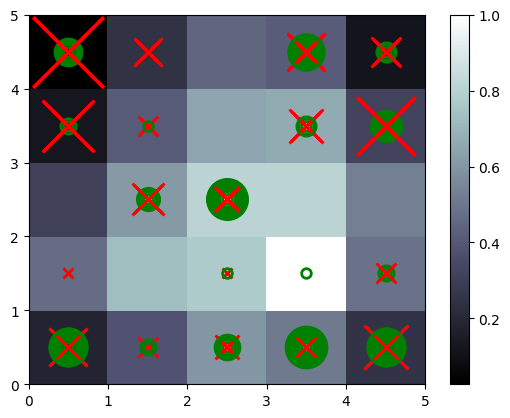

In [42]:
# Initialize 2D array to keep track of paying counts.
paying_counts = np.zeros((x_dim, y_dim, 2))  # The third dimension stores non-paying and paying counts respectively.

# Visualize the SOM
bone()
pcolor(self_organizing_map.distance_map().T)
colorbar()
markers = ['x', 'o']
colors = ['r', 'g']
for i_sample, sample in enumerate(dataset_array):
  w = self_organizing_map.winner(sample)
  i_marker = is_paying[i_sample]
  
  # Update counts in the respective cell.
  paying_counts[w][i_marker] += 1

  # Determine the size of the marker.
  markersize = 10 * np.log1p(paying_counts[w][i_marker])  # Scaling using the log function to reduce skewness.
  
  plot(w[0] + 0.5, w[1] + 0.5, markers[i_marker], markeredgecolor = colors[i_marker], markerfacecolor = 'None', markersize = markersize, markeredgewidth = 2)
plt.show(block=False)

## Categorizing Data

Now, we'll assign each data point to its respective Best Matching Unit (BMU). Following this, we will categorize each BMU based on the percentage of paying users it contains.

In [43]:
# Find winning nodes
dataframe = pd.DataFrame()
bmus = []
for _, input_row in enumerate(dataset_array):
  bmu = self_organizing_map.winner(input_row)
  bmus.append(str((bmu[0],bmu[1])))
dataframe["workspace_id"] = ids
dataframe["is_paying"] = is_paying
dataframe["best_matching_unit"] = np.array(bmus)
dataframe["bmu_category"] = "Unassigned"

# Assign category based on percentage of payers in each bmu
bmu_dict = dict.fromkeys(bmus,"Unassigned")
for bmu in bmus:
  temp_df = dataframe.loc[dataframe['best_matching_unit'] == bmu]
  num_workspaces = len(temp_df.index)
  if len(temp_df.is_paying.unique()) > 1:
    is_paying_counts = temp_df.is_paying.value_counts()
    percentage_paying = is_paying_counts[1]/(is_paying_counts[0]+is_paying_counts[1])
    if percentage_paying < .5:
      bmu_dict[bmu] = "<50 percent paying | n = %s" % (num_workspaces)
    else:
      bmu_dict[bmu] = ">50 percent paying | n = %s" % (num_workspaces)
  elif temp_df.is_paying.unique() == 1:
    bmu_dict[bmu] = "100 percent paying | n = %s" % (num_workspaces)
  elif temp_df.is_paying.unique() == 0:
    bmu_dict[bmu] = "  0 percent paying | n = %s" % (num_workspaces)

for bmu in bmus:
  col_is_bmu = (dataframe.best_matching_unit == bmu)
  dataframe.loc[col_is_bmu, 'bmu_category'] = bmu_dict[bmu]

## Exporting Results

Finally, we'll export our processed data, containing the assigned BMUs and their respective categories, to a CSV file.

In [44]:
dataframe.to_csv("/Users/stephenkiss/Applications/platform_payment_som/data/output/final_dataframe.csv", index=False)
print(dataframe)

     workspace_id  is_paying best_matching_unit                 bmu_category
0               1          0             (0, 1)     0 percent paying | n = 1
1               2          0             (2, 1)   >50 percent paying | n = 2
2               3          1             (2, 1)   >50 percent paying | n = 2
3               4          0             (2, 0)  >50 percent paying | n = 10
4               5          0             (1, 0)   <50 percent paying | n = 5
..            ...        ...                ...                          ...
487           488          0             (4, 3)  <50 percent paying | n = 71
488           489          0             (4, 3)  <50 percent paying | n = 71
489           490          1             (4, 3)  <50 percent paying | n = 71
490           491          0             (4, 3)  <50 percent paying | n = 71
491           492          0             (4, 3)  <50 percent paying | n = 71

[492 rows x 4 columns]
